In [1]:
import pandas as pd
import numpy as np

import os
import torch

from matplotlib import pyplot as plt

from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

In [2]:
dt = pd.read_csv('/kaggle/input/homework6/algos.csv', sep=',', header=None)
dt.values

array([[-1.    , -0.5   ,  0.    , -0.5   ,  0.5   ,  0.5   ,  0.    ,
         0.5   ,  1.    ],
       [ 0.0625,  0.0625,  0.0625,  0.0625,  0.0625,  0.0625,  0.0625,
         0.0625,  0.0625]])

In [3]:
filter1 = dt.values[0].reshape(3, 3)
filter2 = dt.values[1].reshape(3, 3)

In [4]:
class MyDataset(Dataset):
    def __init__(self, folder, transform, len_dataset=1000):
        self.folder = folder
        self.transform = transform
        self.len_dataset = len_dataset

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.folder,
                                str(idx + 1) + '.png')
        txt_path = os.path.join(self.folder,
                                str(idx + 1) + '.txt')

        image = torchvision.io.read_image(img_path)
        real_conv = torch.from_numpy(np.loadtxt(txt_path))

        return image, real_conv

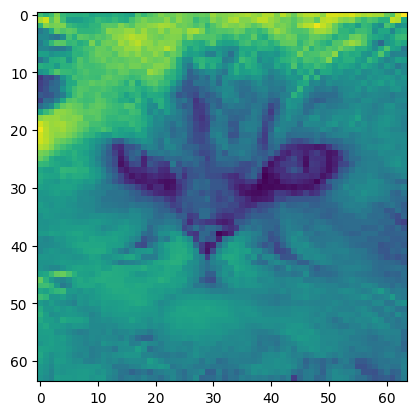

tensor([324.8164, 364.2344, 353.4336, 333.4570, 311.2969, 293.3203, 286.9883,
        288.8242, 294.0000, 300.7383, 307.1953, 312.2969, 315.2305, 315.8789,
        317.9219, 326.6406, 340.8320, 353.1094, 359.9805, 365.1445, 370.5703,
        373.3359, 372.5117, 369.7109, 364.7539, 356.8672, 348.2930, 343.9531,
        347.2344, 355.9453, 365.7500, 374.1953, 380.4766, 383.7383, 382.7422,
        379.7109, 379.4883, 383.7734, 388.2383, 387.4961, 381.6758, 373.7578,
        366.6289, 364.8750, 372.1562, 384.9727, 394.5312, 398.8320, 402.4492,
        404.1250, 397.9688, 384.6992, 371.1680, 360.2539, 351.0820, 343.7734,
        337.5352, 330.2148, 324.5234, 328.2617, 339.9453, 326.7383, 229.5977,
         33.4297], dtype=torch.float64)
tensor([[174, 160, 172,  ..., 182, 223, 244],
        [213, 226, 184,  ..., 223, 217, 154],
        [163, 202, 194,  ..., 165, 127, 135],
        ...,
        [137, 131, 122,  ...,  99, 100, 114],
        [136, 129, 118,  ...,  85,  89, 112],
        [132, 1

In [5]:
transform = transforms.ToTensor()
hw_dataset = MyDataset(folder='/kaggle/input/homework6',
                       transform=transform)

fig = plt.figure()

datal = DataLoader(hw_dataset)
random_batch = next(iter(hw_dataset))
img, res_ten = random_batch[0].squeeze(), random_batch[1][0]
plt.imshow(img)
plt.show()
print(res_ten)
print(random_batch[0].squeeze())

In [6]:
class FilterNet(nn.Module):
    def __init__(self, F1, F2):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.conv1.weight = nn.Parameter(F1, requires_grad=False)

        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.conv2.weight = nn.Parameter(F2, requires_grad=False) 

        self.conv3 = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        nn.init.normal_(self.conv3.weight, mean=0.0, std=0.1)

    def forward(self, x, ord=1):
        if ord == 1:
          x = self.conv1(x)
          x = self.conv2(x)
          x = self.conv3(x)
        elif ord == 2:
          x = self.conv2(x)
          x = self.conv1(x)
          x = self.conv3(x)
        elif ord == 3:
          x = self.conv1(x)
          x = self.conv3(x)
          x = self.conv2(x)
        elif ord == 4:
          x = self.conv2(x)
          x = self.conv3(x)
          x = self.conv1(x)
        elif ord == 5:
          x = self.conv3(x)
          x = self.conv1(x)
          x = self.conv2(x)
        else:
          x = self.conv3(x)
          x = self.conv2(x)
          x = self.conv1(x)

        return x
            

In [10]:
BATCH_SIZE = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_loader = DataLoader(hw_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

F1 = torch.from_numpy(filter1).float().unsqueeze(0).unsqueeze(0).to(device)
F2 = torch.from_numpy(filter2).float().unsqueeze(0).unsqueeze(0).to(device)

model = FilterNet(F1, F2).to(device)
optimizer = torch.optim.Adam(model.conv3.parameters(), lr=1e-2)

losses=[]
for epoch in range(1000):
    total_loss = 0
    for X_batch, Y_batch in data_loader:
        optimizer.zero_grad()
        X_batch = X_batch.float().to(device)
        Y_batch = Y_batch.float().to(device)
        Y_batch = Y_batch.unsqueeze(0)
        Y_batch = Y_batch.view(BATCH_SIZE, 1, 64, 64)
        Y_pred = model(X_batch, ord=4)
        loss = F.mse_loss(Y_pred, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= 10
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Total Loss: {total_loss:.6f}')
    losses.append(total_loss)

Epoch 0, Total Loss: 9484.388037
Epoch 10, Total Loss: 12.148502
Epoch 20, Total Loss: 9.439166
Epoch 30, Total Loss: 7.613808
Epoch 40, Total Loss: 6.021295
Epoch 50, Total Loss: 4.633491


KeyboardInterrupt: 

In [19]:
for epoch in range(1000):
    total_loss = 0
    for X_batch, Y_batch in data_loader:
        optimizer.zero_grad()
        X_batch = X_batch.float().to(device)
        Y_batch = Y_batch.float().to(device)
        Y_batch = Y_batch.unsqueeze(0)
        Y_batch = Y_batch.view(BATCH_SIZE, 1, 64, 64)
        Y_pred = model(X_batch, ord=4)
        loss = F.mse_loss(Y_pred, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= 10
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Total Loss: {total_loss:.6f}')
    losses.append(total_loss)

Epoch 0, Total Loss: 0.000006
Epoch 10, Total Loss: 0.111111
Epoch 20, Total Loss: 0.050138
Epoch 30, Total Loss: 0.000005
Epoch 40, Total Loss: 0.000005
Epoch 50, Total Loss: 0.000003
Epoch 60, Total Loss: 0.137217
Epoch 70, Total Loss: 0.000022
Epoch 80, Total Loss: 0.000002
Epoch 90, Total Loss: 0.000001
Epoch 100, Total Loss: 0.000001
Epoch 110, Total Loss: 0.004127
Epoch 120, Total Loss: 0.001067
Epoch 130, Total Loss: 0.000037
Epoch 140, Total Loss: 0.002499
Epoch 150, Total Loss: 0.143934
Epoch 160, Total Loss: 0.000005
Epoch 170, Total Loss: 0.000000
Epoch 180, Total Loss: 0.022116
Epoch 190, Total Loss: 0.000001
Epoch 200, Total Loss: 0.000002
Epoch 210, Total Loss: 0.000000
Epoch 220, Total Loss: 0.000002
Epoch 230, Total Loss: 0.000262
Epoch 240, Total Loss: 0.000000
Epoch 250, Total Loss: 0.000000
Epoch 260, Total Loss: 0.000000
Epoch 270, Total Loss: 0.000000


KeyboardInterrupt: 

In [20]:
print("Восстановленный фильтр F3 для 2 3 1:")
print(model.conv3.weight.detach().cpu().numpy())

Восстановленный фильтр F3 для 2 3 1:
[[[[0.12490092 0.2500796  0.12491162]
   [0.25007936 0.49974173 0.25007898]
   [0.1249117  0.25007874 0.12490058]]]]


In [21]:
filter_1 = filter1.reshape(-1)
filter_2 = filter2.reshape(-1)
filter_3 = np.array([0.125, 0.25, 0.125, 0.25, 0.5, 0.25, 0.125, 0.25, 0.125])#model.conv3.weight.detach().cpu().numpy().reshape(-1)
filters = np.array([ filter_2, filter_3, filter_1])
np.savetxt("reconstructed_algos.csv", filters, delimiter=",")